In [23]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bold_dementia.utils.configuration import get_config
from bold_dementia.utils.saving import save_run
from bold_dementia.stats.univariate import make_fc_data, run_test, export_results, merge_configs
from bold_dementia.connectivity import reshape_pvalues, plot_matrix, Atlas, pivot_resdf, edges_to_matrix

ALPHA = config["alpha"]

In [24]:
ATLAS = "GINNA"
atlas = Atlas.from_name(ATLAS)

In [25]:
expname = f"atlas-{ATLAS}_merged_ols-cenanom"
respath = Path(config["output_dir"]) / "statresults" / expname

In [26]:
null = pd.read_csv(respath / "null_distribution_5000.csv", index_col=0)
resdf = pd.read_csv(respath / "resdf.csv", index_col=0)

In [27]:
permutation_scores = null.select_dtypes(float).values # Last col is edge name
score = resdf["beta_AD"].values
score = np.stack([score for _ in range(permutation_scores.shape[1])], axis=1) # Make scores broadcastable on permutation_scores

In [28]:
np.abs(permutation_scores) >= np.abs(score)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True, False,  True, ..., False,  True, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [29]:
# From https://stats.libretexts.org/Courses/Saint_Mary's_College_Notre_Dame/MATH_346_-_Statistics_(Kuter)/Labs/Lab_2%3A_Intro_to_Hypothesis_Testing_-_Permutation_Tests
# "When performing a two-sided permutation test, 
# we calculate both one-sided 𝑃-values, multiply 
# the smaller by 2, and if necessary round down to 1.0."

N = permutation_scores.shape[1]
pvalues_less = (np.sum(permutation_scores <= score, axis=1)) / (N)
pvalues_more = (np.sum(permutation_scores >= score, axis=1)) / (N)
pvalues = np.minimum(pvalues_less, pvalues_more) * 2
assert np.all(pvalues <= 1) # Otherwise we should clip high values to 1

In [30]:
np.sum(pvalues < 0.05)

131

In [31]:
from statsmodels.stats.multitest import fdrcorrection
print(f"Correcting FDR with {len(pvalues)} comparisons")
_, pvalues_corr = fdrcorrection(pvalues, method="poscorr")

Correcting FDR with 528 comparisons


In [32]:
np.sum(pvalues_corr <= config["alpha"])

41

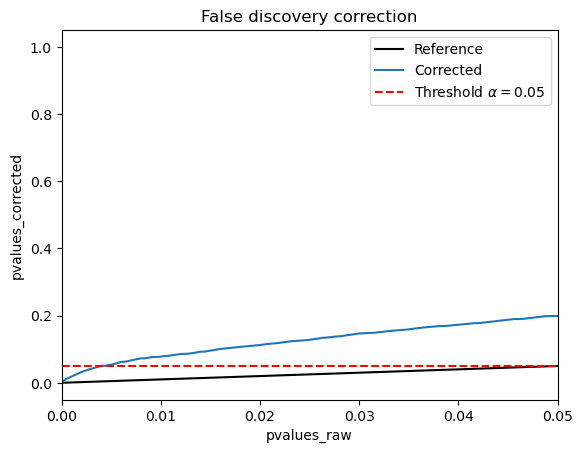

In [33]:
from bold_dementia.stats.fdr import plot_fdr

plot_fdr(pvalues, pvalues_corr)
plt.show()

In [39]:
from bold_dementia.connectivity import edges_to_matrix
ALPHA = 0.01
resdf["pvalues_perm_fdr"] = pvalues_corr
resdf["thresholded_beta"] = np.where(pvalues_corr <= ALPHA, resdf.beta_AD, 0)
pv = edges_to_matrix(resdf)

In [40]:
from bold_dementia.visualisation.chord_plot import make_links, create_chord
matrix_df = pv.thresholded_beta
links = make_links(matrix_df, zoom=10)

RSN04 RSN26 -0.111201612722296 1.11201612722296
RSN04 RSN32 -0.0963714171539259 0.963714171539259
RSN06 RSN07 0.0742168658067521 0.7421686580675211
RSN07 RSN06 0.0742168658067521 0.7421686580675211
RSN07 RSN32 -0.0804336046252705 0.8043360462527049
RSN09 RSN26 -0.1078525485051023 1.078525485051023
RSN09 RSN27 0.0881464804322531 0.8814648043225309
RSN09 RSN28 0.1111149260703378 1.111149260703378
RSN09 RSN32 -0.1077465845206948 1.077465845206948
RSN10 RSN28 0.1084854934605478 1.0848549346054779
RSN10 RSN32 -0.1158877131263505 1.1588771312635051
RSN11 RSN22 -0.0755598981504151 0.755598981504151
RSN12 RSN15 0.1149737638466759 1.149737638466759
RSN15 RSN12 0.1149737638466759 1.149737638466759
RSN15 RSN33 0.0874298889457856 0.874298889457856
RSN20 RSN26 -0.1087227436714924 1.087227436714924
RSN20 RSN28 0.0876667908608474 0.876667908608474
RSN22 RSN11 -0.0755598981504151 0.755598981504151
RSN26 RSN04 -0.111201612722296 1.11201612722296
RSN26 RSN09 -0.1078525485051023 1.078525485051023
RSN26 R

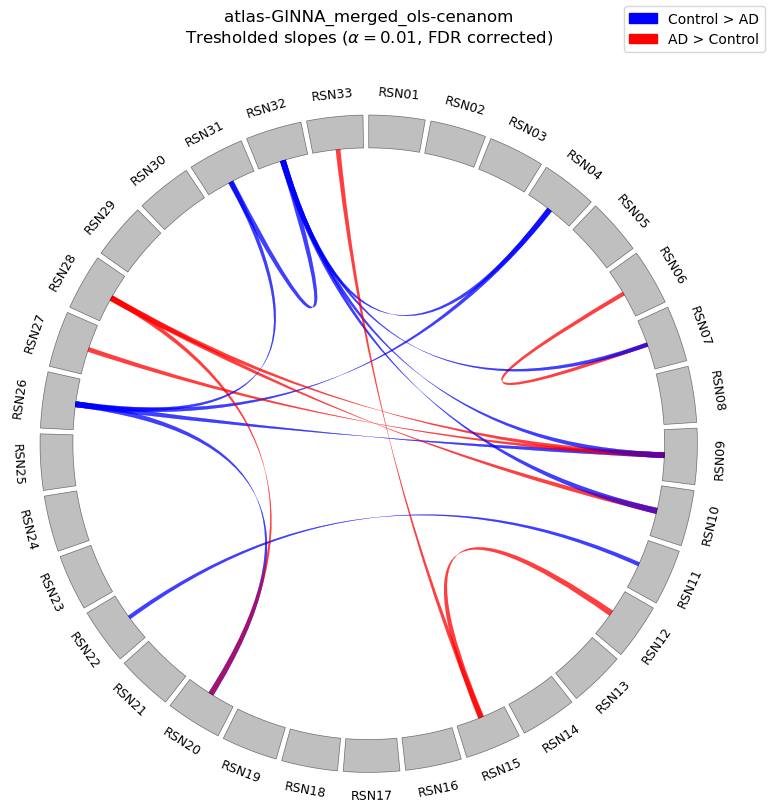

In [41]:
import matplotlib.patches as mpatches

blue_patch = mpatches.Patch(color='blue', label='Control > AD')
red_patch = mpatches.Patch(color='red', label='AD > Control')

networks = matrix_df.columns.to_list()
fig = create_chord(networks, links, size=9)
fig.legend(handles=[blue_patch, red_patch])
fig.suptitle(
    f"{expname}\nTresholded slopes ($\\alpha = ${ALPHA}, FDR corrected)",
    y=1.01
)
plt.show()

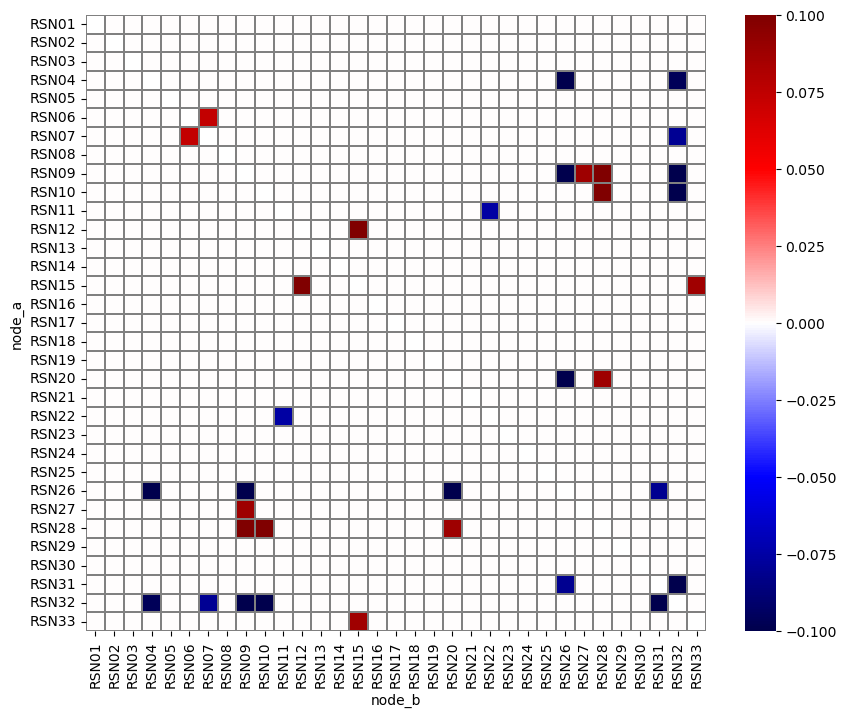

In [42]:
span = np.max(np.abs(matrix_df.values))
plt.subplots(figsize=(10, 8))
sns.heatmap(matrix_df, vmin=-span, vmax=span, cmap="seismic", linewidths=0.1, linecolor="gray")
plt.show()

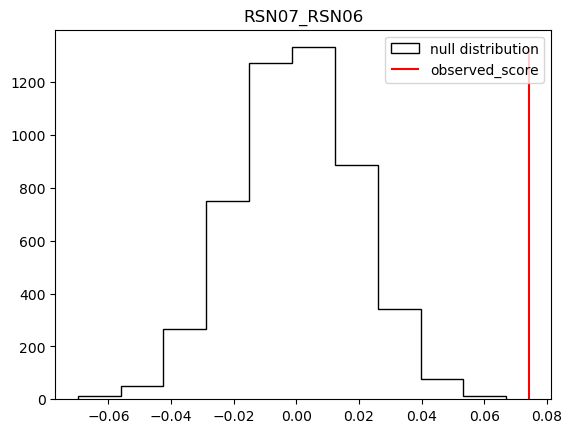

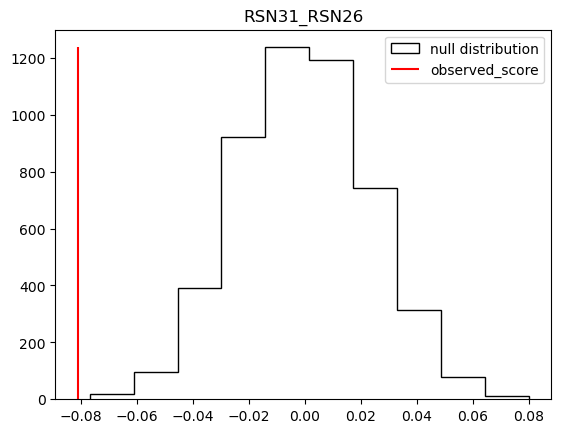

In [43]:

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

sig_idx = np.where(pvalues_corr <= ALPHA)[0]

for idx in sig_idx[::10]:
    reference = permutation_scores[idx, :]
    observed_score = resdf.loc[idx, "beta_AD"]
    values, _, _ = plt.hist(reference, histtype="step", color="black", label="null distribution")
    plt.vlines(observed_score, 0, np.max(values), color="red", label="observed_score")
    plt.title(resdf.loc[idx, "edges"])
    plt.legend()
    plt.show()